In [1]:
import numpy as np
import sys
import pandas as pd
import csv
import wradlib as wrl
import copy
import warnings
import matplotlib as mpl
from matplotlib import pyplot as plt

from rcit.extrapolation.extrapolation_methods import semi_lagrangian_expol
from rcit.motion.global_motion_estimation import global_motion_generation_piv, global_motion_generation_vet
from rcit.radar_data_io.read_dx_data import read_dwd_dx_radar_data

from rcit.cell_segment.cell_props import get_props_modelled_cell
from rcit.cell_segment.cell_props import excell_model_func, dexcell_model_func, hycell_model_func
from rcit.cell_segment.cell_segment_methods import rain_cell_modelling
from rcit.cell_segment.cell_segment_methods import segment_watershed

from rcit.util.general_methods import global_motion_static

from rcit.cell_tracking.raincell_tracking import get_most_likely_child_rain_cell, get_child_rain_cell

from rcit.util.pre_process.pre_process import input_filter
from rcit.verify.veri_categorical import categorical_cal
from rcit.verify.veri_sal import sal_veri


0.3.0


In [2]:
warnings.filterwarnings('ignore')

In [3]:
# define the color-bar of radar reflectivity, which is suitable for the DWD
def reflectivity_colormap():
    reflectivity_colors = ["#FFFFFF",  # 0 --- 0.02 --- 0.002
                           "#00FFFF",  # 4 --- 0.04 --- 0.003
                           "#43C6DB",  # 8 --- 0.07 --- 0.006
                           "#0000A0",  # 12 --- 0.14 --- 0.012
                           "#00FF00",  # 16 --- 0.27 --- 0.022
                           "#52D017",  # 20 --- 0.52 --- 0.043
                           "#347235",  # 24 --- 0.99 --- 0.082
                           "#FFFF00",  # 28 --- 1.89 --- 0.157
                           "#EAC117",  # 32 --- 3.61 --- 0.301
                           "#F88017",  # 36 --- 6.91 --- 0.576
                           "#FF0000",  # 40 --- 13.21 --- 1.101
                           "#E41B17",  # 44 --- 25.27 --- 2.106
                           "#C11B17",  # 48 --- 48.34 --- 4.029
                           "#F660AB",  # 52 --- 92.48 --- 7.706
                           "#8E35EF",  # 56 --- 176.90 --- 14.741
                           "#000000",  # 60 --- 338.38 --- 28.199
                           ]
    cmap = mpl.colors.ListedColormap(reflectivity_colors)
    return cmap

ref_colormap = reflectivity_colormap()


In [4]:
def write_csv(csv_path, M):
    with open(csv_path, 'w', encoding='utf-8', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerows(M)


In [5]:
# set forecast dataset, totally we choose 27 radar images, the first three is used for global motion calculation, 
# and the next 24 is used for 2-hr nowcasting and correspondly verification
# 2007-05-26, 0-27(00:00); 244-271(20:20); 252-279(21:00). 
# 2008-07-19 192-219(16:00); 
# 2008-07-26 0-27(00:00); 192-219(16:00); 217-244(18:05).

f = open("./080726/ein_bild.dat")
lines = f.readlines()
lines1 = lines[217:244]
radar_images = np.full((27, 256, 256), np.nan)
radar_images_filtered = np.full((27, 256, 256), np.nan)
radar_images_intensities = np.full((27, 256, 256), np.nan)
labeled_rain_cells = np.zeros((27, 256, 256), dtype='int')

# property list of identified rain cell
cell_label = []
cell_area = []
cell_center = []
cell_coord = []
cell_bbox = []
cell_bbox_boun = []


In [6]:
# excuation of segmentation pocedure for the selected radar images
# and the EXCELL rainfall model is applied to model the segmented rain cells

t = 0
r2 = 5

for lines2 in lines1:
    line = lines2.split('\n')
    line1 = lines2.split('.ess\n')
    print(line1[0][2:])
    print(line[0])

    reflectivity, intensity = read_dwd_dx_radar_data("./080726/" + line[0], 6.964, 51.4064, 152, 128000)
    origin_ref, filter_ref = input_filter(reflectivity, 'cf')
    origin_intensity, filter_intensity = input_filter(intensity, 'cf')
    filter_intensity[np.isnan(filter_intensity)] = 0
    intensity[np.isnan(intensity)] = 0
    filter_intensity_1 = copy.deepcopy(filter_intensity)
    filter_intensity_2 = copy.deepcopy(filter_intensity)

    label_modelled_cluster = segment_watershed(filter_intensity, 1, 9)
    filter_intensity_2[label_modelled_cluster==0]=0
    
    label_modelled_cell = rain_cell_modelling(filter_intensity_2, r2, 9, 35)
    
    radar_images[t, :, :] = reflectivity
    radar_images_filtered[t, :, :] = filter_intensity_1
    radar_images_intensities[t, :, :] = intensity
    labeled_rain_cells[t, :, :] = label_modelled_cell

    cell_props, hycell_props, df_cells = get_props_modelled_cell(filter_intensity_1, label_modelled_cell)
    print(df_cells)

    label = [temp[0] for temp in cell_props]
    area = [temp[1] for temp in cell_props]
    peak_r = [temp[2] for temp in hycell_props]
    center = [temp[2] for temp in cell_props]
    coords = [temp[3] for temp in cell_props]
    bbox = [temp[4] for temp in cell_props]
    bbox_search = [temp[5] for temp in cell_props]
    ellip = [temp[3] for temp in hycell_props]
    r_mean = [temp[4] for temp in hycell_props]
    rms_r = [temp[5] for temp in hycell_props]
    grad_mean = [temp[6] for temp in hycell_props]
    rms_grad = [temp[7] for temp in hycell_props]
    long_axis = [temp[8] for temp in hycell_props]

    params_excell, model_params = excell_model_func(r2, area, peak_r, rms_r, ellip, grad_mean, rms_grad)
    # params_hycell, model_parmas = hycell_model_func(r2, area, peak_r, r_mean, rms_r, ellip, grad_mean,
    #                                                 rms_grad, re_ini, r1_ini)
    print(model_params)

    cell_label.append(label)
    cell_area.append(area)
    cell_center.append(center)
    cell_coord.append(coords)
    cell_bbox.append(bbox)
    cell_bbox_boun.append(bbox_search)
    
    radar_images_intensities[t, :, :][labeled_rain_cells[t, :, :]==0]=0
    
    t += 1


0807261805
dx0807261805.ess
    label  area  peak_r     e     a_r   rms_r  a_grad  rms_grad  long_a
0       1   9.0  326.78  1.00  272.60  283.38   82.06    108.42     3.0
1       2  22.0  325.57  0.79  238.60  233.14  101.35    123.06     6.0
2       3  28.0  301.01  0.81  168.11  164.29   89.16    104.16     7.0
3       4  38.0  264.72  0.55  154.00  139.93   87.39    103.08     9.0
4       5  33.0  241.30  0.60  154.54  138.28   84.00     95.08     9.0
5       6  16.0  238.57  0.34  142.68  131.55   87.02     92.21     8.0
6       7  25.0  237.50  0.57  181.24  140.72  100.26    120.94     8.0
7       8  33.0  217.58  0.63  144.72  108.40   60.31     77.49     9.0
8       9  19.0  202.98  0.71  129.04  110.15   91.32     99.14     6.0
9      10  31.0  202.66  0.43  114.59   86.28   52.71     69.31    10.0
10     11  26.0  196.08  0.93  124.91  114.61   81.98     92.91     6.0
11     12  57.0  190.19  0.83  110.95   88.98   39.15     50.69    10.0
12     13  25.0  190.11  0.79  160.3

In [7]:
# Global motion estimation with pyRCIT algorithm
time_list = 27
global_vectors_RCIT = [[] for i in range(0, time_list)]
vectors_RCIT = np.zeros((time_list, 2), dtype=float)

global_vectors_VET = [[] for i in range(0, time_list)]
vectors_VET = np.zeros((time_list, 2), dtype=float)
factors = [2, 4, 8, 16, 32]

time_lists = np.arange(0, time_list-1)

for i in time_lists:
    print(i)
    i = int(i)

    # profile = line_profiler.LineProfiler(global_motion_generation_piv)
    # profile.enable()
    location_motion_RCIT, motion_RCIT = global_motion_generation_piv(radar_images_filtered[i], radar_images_filtered[i+1], 16, 16, 0.5, 0.5, 5, 5, [256, 256], 0.1, 5)
    motion_VET, intermediate_steps = global_motion_generation_vet(radar_images_filtered[i], radar_images_filtered[i+1], factors, verbose=True, intermediate_steps=True, smooth_gain=1000)
    # profile.disable() # stop analyzing
    # profile.print_stats(sys.stdout) # print result
    
    wind_direction_bins_rcit, mean_speed_rcit = global_motion_static(motion_RCIT)
    wind_direction_bins_vet, mean_speed_vet = global_motion_static(motion_VET)

    global_vectors_RCIT[i] = motion_RCIT
    vectors_RCIT[i, 0] = wind_direction_bins_rcit
    vectors_RCIT[i, 1] = mean_speed_rcit
    
    global_vectors_VET[i] = motion_VET
    vectors_VET[i, 0] = wind_direction_bins_vet
    vectors_VET[i, 1] = mean_speed_vet
    print('prevailing wind direction with rcit is: ', vectors_RCIT[i, 0], 'mean speed with rcit is: ', vectors_RCIT[i, 1])
    print('prevailing wind direction with vet is: ', vectors_VET[i, 0], 'mean speed with vet is: ', vectors_VET[i, 1])


0
Running VET algorithm
original image shape: (2, 256, 256)
padded image shape: (2, 256, 256)
padded template_image image shape: (2, 256, 256)

Number of sectors: 2,2
Sector Shape: (128, 128)
Minimizing
         Current function value: 5678836.496178
         Iterations: 22
         Function evaluations: 91
         Gradient evaluations: 79

residuals 5678836.496178499
smoothness_penalty 0.0
original image shape: (2, 256, 256)
padded image shape: (2, 256, 256)
padded template_image image shape: (2, 256, 256)

Number of sectors: 4,4
Sector Shape: (64, 64)
Minimizing
         Current function value: 5332227.170193
         Iterations: 3
         Function evaluations: 65
         Gradient evaluations: 53

residuals 5332227.169362402
smoothness_penalty 0.0008304348946942486
original image shape: (2, 256, 256)
padded image shape: (2, 256, 256)
padded template_image image shape: (2, 256, 256)

Number of sectors: 8,8
Sector Shape: (32, 32)
Minimizing
         Current function value: 4994292.3

In [8]:
# print(cell_area)
# print(cell_center)
# print(cell_coord)

# get the trajectory of rain cell by the VET algorithm
all_child_cell_label, all_child_cell_center, all_child_cell_area, all_child_cell_coord = get_child_rain_cell(time_list, cell_label, cell_coord, cell_bbox, cell_bbox_boun, cell_center, cell_area)

child_cells = get_most_likely_child_rain_cell(time_list, cell_center, cell_label, cell_coord, cell_area, all_child_cell_center, all_child_cell_label, all_child_cell_coord, all_child_cell_area, vectors_RCIT, 40, 20, 4)

for i in range(time_list):
    line1 = lines1[i].split('.ess\n')
    print(len(child_cells[i]))
    for j in range(len(child_cells[i])):
        print('Child cell Id for cell ' + str(j + 1) + ' at time ' + line1[0][2:] + ' is: ', child_cells[i][j])


40
Child cell Id for cell 1 at time 0807261805 is:  [1, 4, 14]
Child cell Id for cell 2 at time 0807261805 is:  [2]
Child cell Id for cell 3 at time 0807261805 is:  [3]
Child cell Id for cell 4 at time 0807261805 is:  [9, 28]
Child cell Id for cell 5 at time 0807261805 is:  [37]
Child cell Id for cell 6 at time 0807261805 is:  [29]
Child cell Id for cell 7 at time 0807261805 is:  [3]
Child cell Id for cell 8 at time 0807261805 is:  [9]
Child cell Id for cell 9 at time 0807261805 is:  [22, 23]
Child cell Id for cell 10 at time 0807261805 is:  [20]
Child cell Id for cell 11 at time 0807261805 is:  [12]
Child cell Id for cell 12 at time 0807261805 is:  [19]
Child cell Id for cell 13 at time 0807261805 is:  [3]
Child cell Id for cell 14 at time 0807261805 is:  [27]
Child cell Id for cell 15 at time 0807261805 is:  [37]
Child cell Id for cell 16 at time 0807261805 is:  [19]
Child cell Id for cell 17 at time 0807261805 is:  [15]
Child cell Id for cell 18 at time 0807261805 is:  [36]
Child ce

In [9]:
# semi_lagrangian extrapolation by RCIT motion vectors
series_fcst_ref_rcit = semi_lagrangian_expol(radar_images[2, :, :],global_vectors_RCIT[1], 24, outval=np.nan, inverse=True, xy_coords=None, allow_nonfinite_values=True)

# semi_lagrangian extrapolation by VET motion vectors
series_fcst_ref_vet = semi_lagrangian_expol(radar_images[2, :, :],global_vectors_VET[1], 24, outval=np.nan, inverse=True, xy_coords=None, allow_nonfinite_values=True)


In [10]:
# verification pyRCIT nowcasting results by Categorical and SAL methods, respectively
sal_components_rcit = [[] for x in range(0, 24)]
categorical_scores_rcit = [[] for x in range(0, 24)]
sal_components_vet = [[] for x in range(0, 24)]
categorical_scores_vet = [[] for x in range(0, 24)]

for i in range(24):
    observed = radar_images[i + 3]
    forecasted_rcit = series_fcst_ref_rcit[i, :, :]
    forecasted_vet = series_fcst_ref_vet[i, :, :]

    observed_int_z = wrl.trafo.idecibel(observed)
    observed_int = wrl.zr.z_to_r(observed_int_z, a=256., b=1.42)
    fcst_rcit_int_z = wrl.trafo.idecibel(forecasted_rcit)
    fcst_rcit_int = wrl.zr.z_to_r(fcst_rcit_int_z, a=256., b=1.42)
    fcst_vet_int_z = wrl.trafo.idecibel(forecasted_vet)
    fcst_vet_int = wrl.zr.z_to_r(fcst_vet_int_z, a=256., b=1.42)

    s_rcit, a_rcit, l_rcit = sal_veri(observed_int, fcst_rcit_int, thresh=8, vrbl=None, utc=None, lv=None, accum_hr=None, footprint=500, dx=1, dy=1, autofactor=1/15)
    s_vet, a_vet, l_vet = sal_veri(observed_int, fcst_vet_int, thresh=8, vrbl=None, utc=None, lv=None, accum_hr=None, footprint=500, dx=1, dy=1, autofactor=1/15)
    
    csi_rcit, far_rcit, pod_rcit, acc_rcit = categorical_cal(fcst_rcit_int, observed_int, 8)
    sal_components_rcit[i] = [s_rcit, a_rcit, l_rcit]
    categorical_scores_rcit[i] = [csi_rcit, far_rcit, pod_rcit, acc_rcit]
    
    csi_vet, far_vet, pod_vet, acc_vet = categorical_cal(fcst_vet_int, observed_int, 8)
    sal_components_vet[i] = [s_vet, a_vet, l_vet]
    categorical_scores_vet[i] = [csi_vet, far_vet, pod_vet, acc_vet]

df_sal_rcit = pd.DataFrame(sal_components_rcit, columns=list('sal'))
print(df_sal_rcit)
df_categorical_rcit = pd.DataFrame(categorical_scores_rcit, columns=list('cfpa'))
print(df_categorical_rcit)

df_sal_vet = pd.DataFrame(sal_components_vet, columns=list('sal'))
print(df_sal_vet)
df_categorical_vet = pd.DataFrame(categorical_scores_vet, columns=list('cfpa'))
print(df_categorical_vet)


           s         a         l
0  -0.202786 -0.090206  0.061392
1  -0.371831 -0.147879  0.108100
2  -0.643541 -0.179306  0.132480
3  -0.502221 -0.117492  0.138529
4  -0.471232 -0.031246  0.170056
5  -0.147361  0.063033  0.200820
6   0.087318  0.111970  0.188722
7  -0.028428  0.199175  0.274800
8   0.811771  0.193476  0.334838
9   0.375835  0.375086  0.305847
10  0.297509  0.509151  0.405613
11  0.344513  0.642994  0.391304
12  0.238165  0.855505  0.320349
13  0.500543  0.858663  0.499367
14  0.396541  1.037644  0.261024
15  0.401650  1.079278  0.172528
16  2.000000  1.091712  0.835779
17  2.000000  1.023662  0.864293
18  2.000000  1.157847  0.823943
19 -0.372112  1.085339  0.161357
20 -0.939955  1.020090  0.128586
21 -0.388644  0.848094  0.094209
22 -0.830250  0.694308  0.145343
23 -0.499268  0.485408  0.261104
        c      f      p      a
0   0.651  0.171  0.752  0.959
1   0.516  0.253  0.625  0.936
2   0.475  0.289  0.589  0.930
3   0.414  0.368  0.546  0.922
4   0.355  0.457  0.

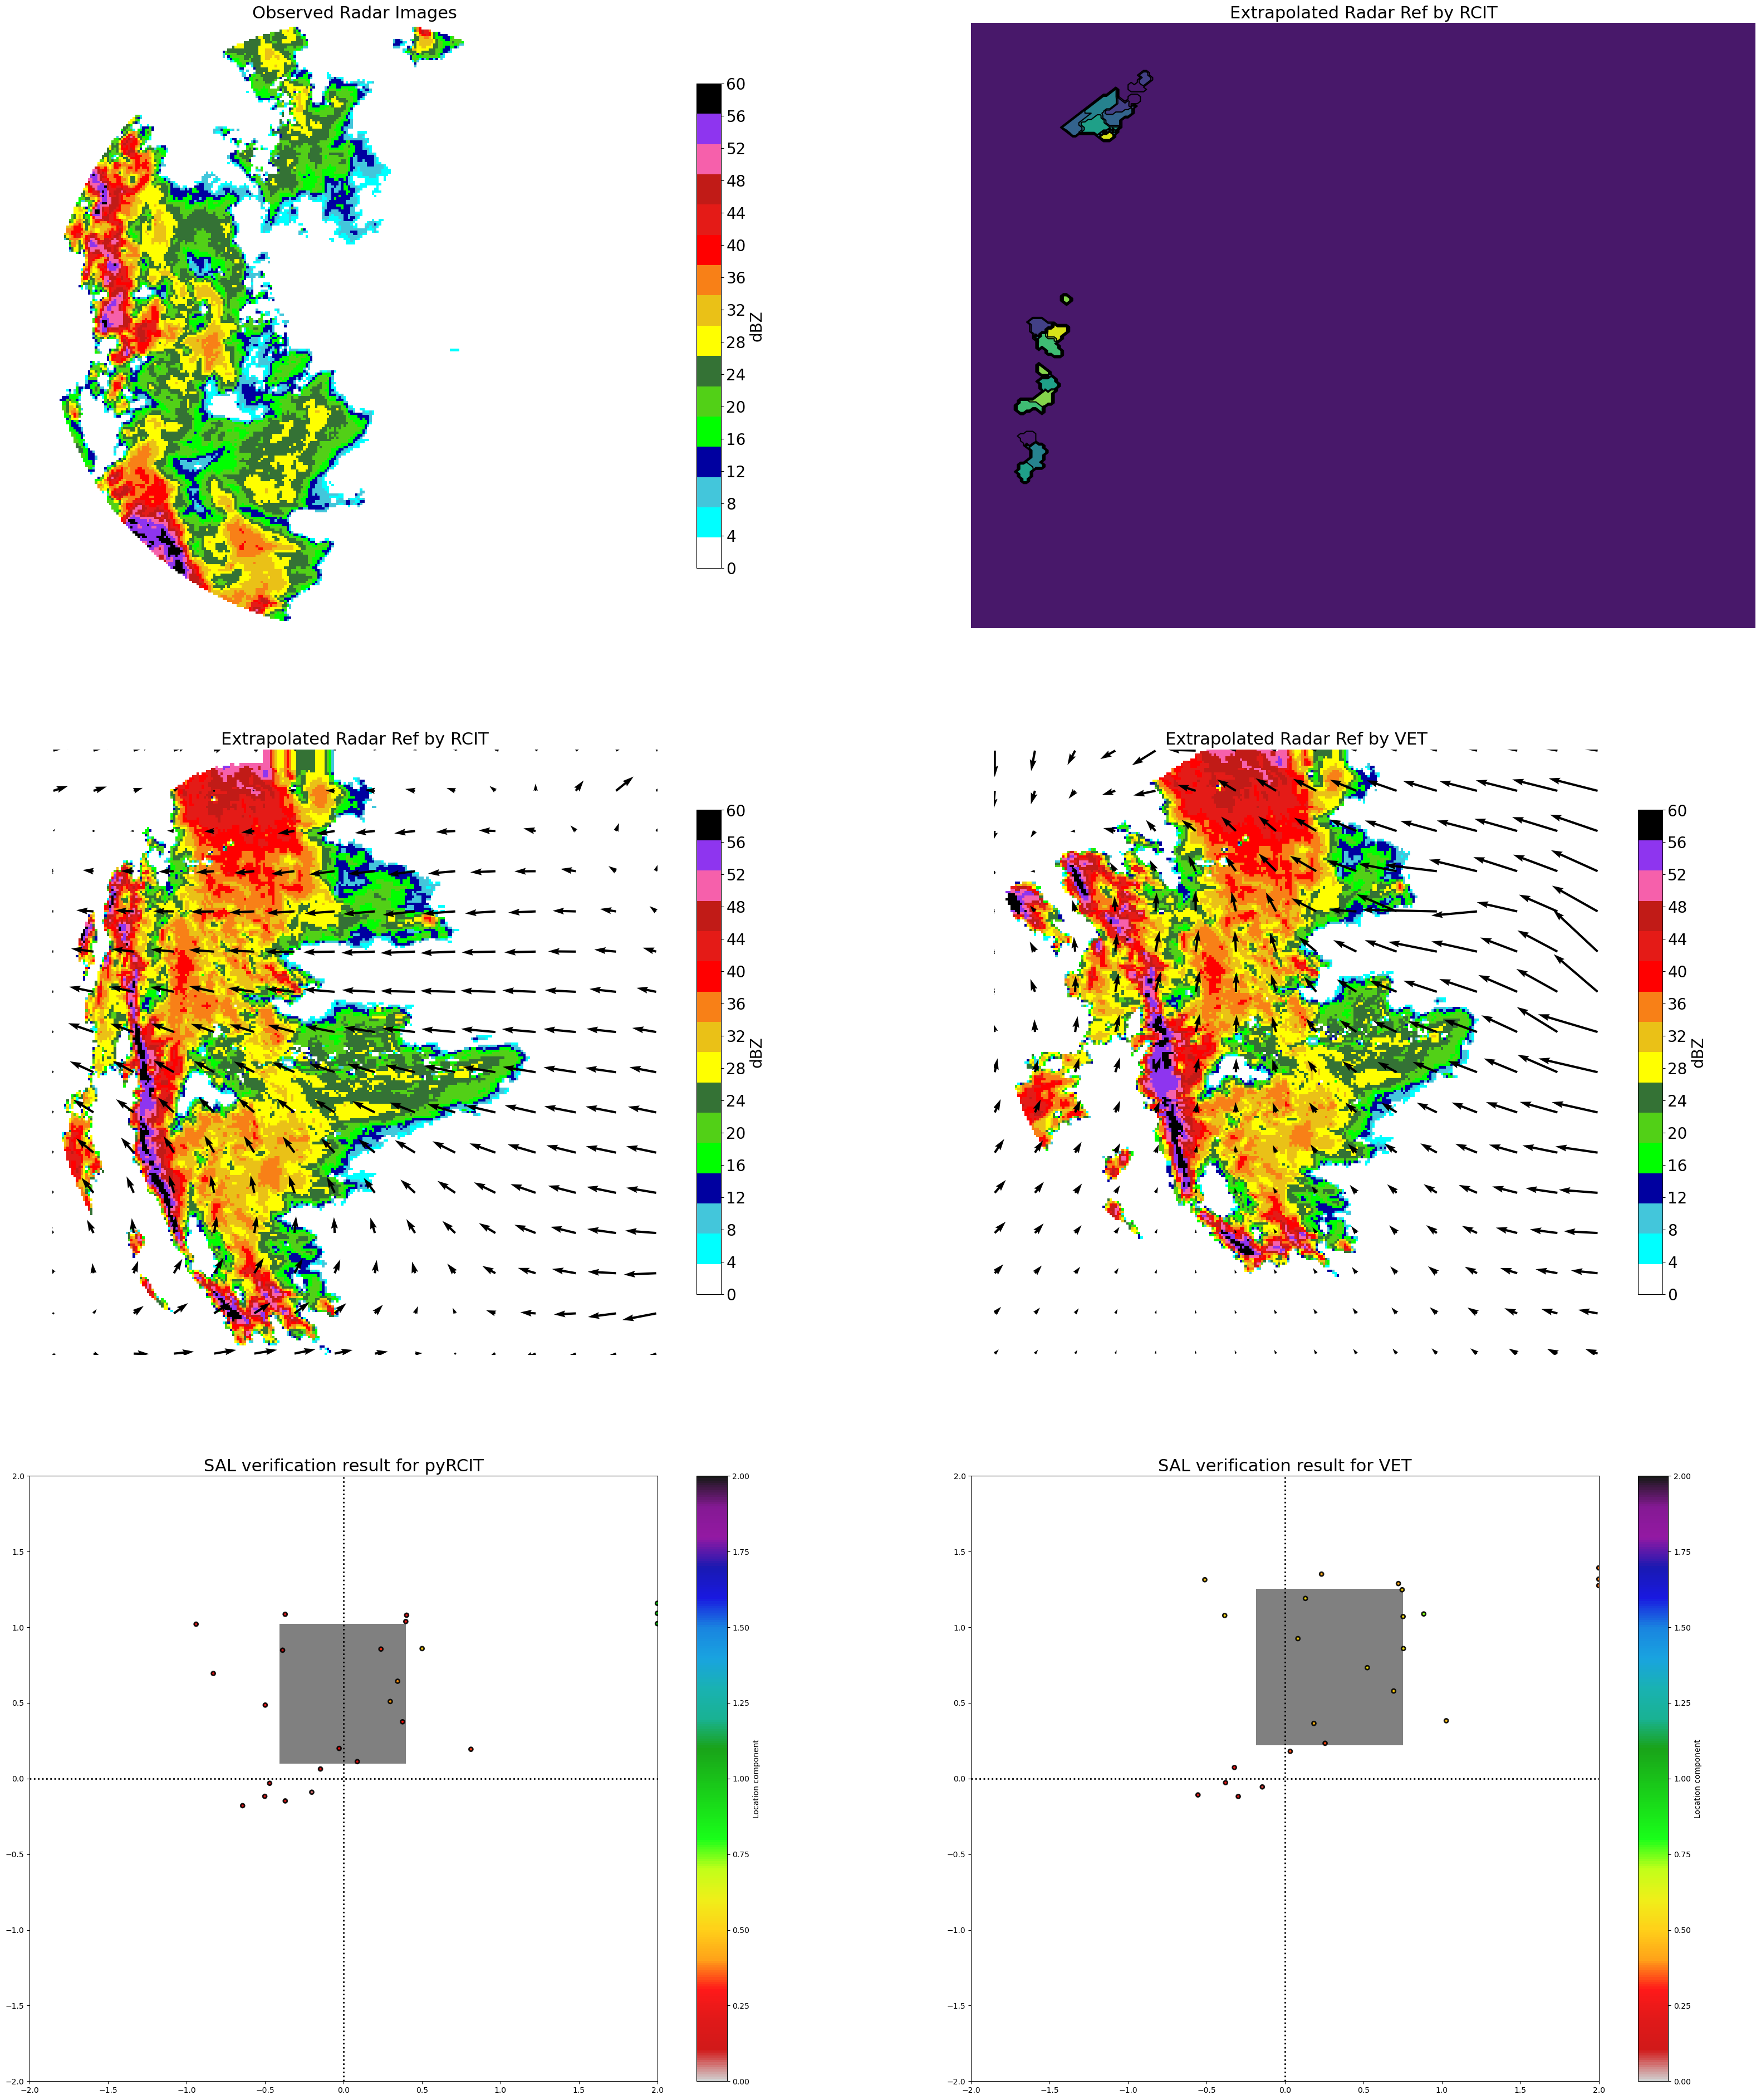

In [11]:
# Visulizing the results
outs = [radar_images[14], labeled_rain_cells[14], series_fcst_ref_rcit[11, :, :], series_fcst_ref_vet[11, :, :]]
titles = ['Observed Radar Images', 'Modelled Rain Cells', 'Extrapolated Radar Ref by RCIT', 'Extrapolated Radar Ref by VET', 'SAL verification result for pyRCIT', 'SAL verification result for VET']

fig, ax = plt.subplots(3, 2, figsize=(40, 48))
ax = ax.flatten()

im0 = ax[0].imshow(outs[0], cmap=ref_colormap, vmin=0, vmax=60)
ax[0].axis('off')
ax[0].set_title(titles[0], fontsize=22)

# im1 = ax[1].imshow(outs[1], cmap=ref_colormap, vmin=0, vmax=338.38)
# ax[1].axis('off')
# ax[1].set_title(titles[1], fontsize=22)


dx=1;dy=1
x=np.arange(0,256,dx)
y=np.arange(0,256,dy)
X,Y=np.meshgrid(x,y)
# def f(x,y):
#     return(1-y**5+x**5)*np.exp(-x**2-y**2)
ax[1].contour(X,Y,outs[1],8,colors='black')  #生成等值线图
ax[1].contourf(X,Y,outs[1],8)
# ax[2].clable(C,inline=1,fontsize=10)

# im2 = ax[2].imshow(outs[2], vmin=0, vmax=60)
ax[1].axis('off')
ax[1].set_title(titles[2], fontsize=22)


im2 = ax[2].imshow(outs[2], cmap=ref_colormap, vmin=0, vmax=60)
ax[2].axis('off')
ax[2].set_title(titles[2], fontsize=22)

im3 = ax[3].imshow(outs[3], cmap=ref_colormap, vmin=0, vmax=60)
ax[3].axis('off')
ax[3].set_title(titles[3], fontsize=22)


cblab = np.array([0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.50, 1.75, 2.0])
sal_rcit = ax[4].scatter(np.asarray(df_sal_rcit.s),
                         np.asarray(df_sal_rcit.a),
                         c=np.asarray(df_sal_rcit.l),
                         vmin=0, vmax=2, s=25,
                         cmap=mpl.cm.nipy_spectral_r, alpha=0.9, edgecolor='k',
                         linewidth=2, zorder=500, marker='o')
ax[4].set(xlim=(-2,2),ylim=(-2,2))
ax[4].axvline(0, color='black', zorder=300, linewidth=2, linestyle=":")
ax[4].axhline(0, color='black', zorder=300, linewidth=2, linestyle=":")
lbS0 = np.percentile(np.asarray(df_sal_rcit.s), 25)
ubS0 = np.percentile(np.asarray(df_sal_rcit.s), 75)
lbA0 = np.percentile(np.asarray(df_sal_rcit.a), 25)
ubA0 = np.percentile(np.asarray(df_sal_rcit.a), 75)
width0 = ubS0 - lbS0
height0 = ubA0 - lbA0
ax[4].add_patch(mpl.patches.Rectangle((lbS0, lbA0), width0, height0, facecolor='grey', alpha=1.0, linewidth=1.0, zorder=100))
ax[4].set_title(titles[4], fontsize=22)

cblab = np.array([0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.50, 1.75, 2.0])
sal_vet = ax[5].scatter(np.asarray(df_sal_vet.s),
                         np.asarray(df_sal_vet.a),
                         c=np.asarray(df_sal_vet.l),
                         vmin=0, vmax=2, s=25,
                         cmap=mpl.cm.nipy_spectral_r, alpha=0.9, edgecolor='k',
                         linewidth=2, zorder=500, marker='o')
ax[5].set(xlim=(-2,2),ylim=(-2,2))
ax[5].axvline(0, color='black', zorder=300, linewidth=2, linestyle=":")
ax[5].axhline(0, color='black', zorder=300, linewidth=2, linestyle=":")
lbS0 = np.percentile(np.asarray(df_sal_vet.s), 25)
ubS0 = np.percentile(np.asarray(df_sal_vet.s), 75)
lbA0 = np.percentile(np.asarray(df_sal_vet.a), 25)
ubA0 = np.percentile(np.asarray(df_sal_vet.a), 75)
width0 = ubS0 - lbS0
height0 = ubA0 - lbA0
ax[5].add_patch(mpl.patches.Rectangle((lbS0, lbA0), width0, height0, facecolor='grey', alpha=1.0, linewidth=1.0, zorder=100))
ax[5].set_title(titles[5], fontsize=22)

pos_x = location_motion_RCIT[0]
pos_y = location_motion_RCIT[1]
v_x_rcit = np.transpose(global_vectors_RCIT[1][0, :, :])
v_y_rcit = np.transpose(global_vectors_RCIT[1][1, :, :])

v_x_vet = np.transpose(global_vectors_VET[1][1, :, :])
v_y_vet = np.transpose(global_vectors_VET[1][0, :, :])

ax[2].quiver(pos_x[::17, ::17], pos_y[::17, ::17], v_x_rcit[::16, ::16], v_y_rcit[::16, ::16],color='black')
ax[3].quiver(pos_x[::17, ::17], pos_y[::17, ::17], v_x_vet[::16, ::16], v_y_vet[::16, ::16],color='black')
#ax[5] = vis.quiver(motion_PYSteps, step=15)

cb0 = plt.colorbar(im0, ax=ax[0], shrink=0.8)
cb0.set_label("dBZ", fontsize=20)
cb0.ax.tick_params(labelsize=20)
cb0.set_ticks(np.linspace(0, 60, 16))

cb2 = plt.colorbar(im2, ax=ax[2], shrink=0.8)
cb2.set_label("dBZ", fontsize=20)
cb2.ax.tick_params(labelsize=20)
cb2.set_ticks(np.linspace(0, 60, 16))

cb3 = plt.colorbar(im3, ax=ax[3], shrink=0.8)
cb3.set_label("dBZ", fontsize=20)
cb3.ax.tick_params(labelsize=20)
cb3.set_ticks(np.linspace(0, 60, 16))

cb4 = plt.colorbar(sal_rcit, ax=ax[4], ticks=cblab, orientation="vertical")
cb4.set_label("Location component")

cb5 = plt.colorbar(sal_vet, ax=ax[5], ticks=cblab, orientation="vertical")
cb5.set_label("Location component")

plt.show()